# Capstone Week 8
---

# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor dictionary mapper](#Make-advisor-dictionary-mapper)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
    - [Regression](#Regression)
        - [Make Function to output deciles](#Make-Function-to-output-deciles)
    - [Classification](#Classification)
        - [Balance the data with `imbalanced-learn`](#Balance-the-data-with-imbalanced-learn)
- [Model Interpretation](#Model-Interpretation)
- [Fairness and Bias](#Fairness-and-Bias)
- [Scratch Work](#Scratch-Work)
    - [Feature Engineering](#Feature-Engineering)
        - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
    - [Residuals](#Residuals)
    - [Condition number](#Condition-number)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', 50)

[Back to Top](#Index)
# Read in Data

In [2]:
df18 = pd.read_excel("../Transaction Data.xlsx", sheet_name="Transactions18")
df19 = pd.read_excel("../Transaction Data.xlsx", sheet_name="Transactions19")
firm = pd.read_excel("../Firm Information.xlsx", sheet_name="Rep summary")

In [3]:
firm.head()

Contact ID  CustomerID  Firm ID             Office ID  \
0    0000286           1  1948520           17993101120   
1    0000422           2  1688552  85202111664692445495   
2    0000508           3  1567450           15674503441   
3    0000604           4  0022885  85102132106001250782   
4    0000657           5  1567450           15674501882   

                  Channel Sub channel                         Firm name  
0  National Broker-Dealer        NACS  Morgan Stanley Wealth Management  
1  National Broker-Dealer        NACS      UBS Financial Services, Inc.  
2  National Broker-Dealer        NACS                     Merrill Lynch  
3      Independent Dealer         IBD                 LPL Financial LLC  
4  National Broker-Dealer        NACS                     Merrill Lynch

## Merge 2018 and 2019

In [4]:
df = pd.merge(
    df18, 
    df19, 
    on='CONTACT_ID',
    suffixes=['_2018', '_2019']
)
print(df.shape)

(10005, 41)


In [5]:
df.head()

CONTACT_ID  no_of_sales_12M_1  no_of_Redemption_12M_1  \
0               0047433               21.0                    38.0   
1               4461312                NaN                     NaN   
2               4491079                NaN                     NaN   
3               0107408               20.0                     NaN   
4  85101140503769936458                NaN                     NaN   

   no_of_sales_12M_10K  no_of_Redemption_12M_10K  no_of_funds_sold_12M_1  \
0                  NaN                       1.0                     5.0   
1                  NaN                       NaN                     NaN   
2                  NaN                       NaN                     NaN   
3                  2.0                       NaN                     1.0   
4                  NaN                       NaN                     NaN   

   no_of_funds_redeemed_12M_1  no_of_fund_sales_12M_10K  \
0                         5.0                       NaN   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                         NaN                       1.0   
4                         NaN                       NaN   

   no_of_funds_Redemption_12M_10K  no_of_assetclass_sold_12M_1  \
0                             1.0                          2.0   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          1.0   
4                             NaN                          NaN   

   no_of_assetclass_redeemed_12M_1  no_of_assetclass_sales_12M_10K  \
0                              2.0                             NaN   
1                              NaN                             NaN   
2                              NaN                             NaN   
3                              NaN                             1.0   
4                              NaN                             NaN   

   no_of_assetclass_Redemption_12M_10K  No_of_fund_curr  No_of_asset_curr  \
0                                  1.0              8.0               1.0   
1                                  NaN              1.0               1.0   
2                                  NaN              NaN               NaN   
3                                  NaN              1.0               1.0   
4                                  NaN              NaN               NaN   

         AUM  sales_curr  sales_12M_2018  redemption_curr  redemption_12M  \
0  237480.11       250.0         19682.0        -1496.745     -102496.165   
1   19629.00         NaN             NaN              NaN             NaN   
2    1758.70         NaN             NaN              NaN             NaN   
3   57943.00      5459.0         52484.0              NaN             NaN   
4   -8573.59         NaN             NaN              NaN             NaN   

   new_Fund_added_12M_2018  aum_AC_EQUITY  aum_AC_FIXED_INCOME_MUNI  \
0                      NaN      -47342.32                 284737.93   
1                      NaN           0.00                  19629.00   
2                      NaN           0.00                   1758.70   
3                      1.0           0.00                      0.00   
4                      NaN       -8573.59                      0.00   

   aum_AC_FIXED_INCOME_TAXABLE  aum_AC_MONEY  aum_AC_MULTIPLE  \
0                         84.5           0.0              0.0   
1                          0.0           0.0              0.0   
2                          0.0           0.0              0.0   
3                      57943.0           0.0              0.0   
4                          0.0           0.0              0.0   

   aum_AC_PHYSICAL_COMMODITY  aum_AC_REAL_ESTATE  aum_AC_TARGET  aum_P_529  \
0                        0.0                 0.0            0.0        0.0   
1                        0.0                 0.0            0.

## Make advisor dictionary mapper

In [6]:
adviser_lookup = {idx: contact_id for idx, contact_id in enumerate(df['CONTACT_ID'])}

In [7]:
adviser_lookup[123]

'85201142414218755394'

[Back to Top](#Index)
# Data Cleaning

In [8]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'refresh_date_2019', 'refresh_date_2018', 'CONTACT_ID', 
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
    'no_of_Redemption_12M_10K', 'no_of_funds_sold_12M_1',
    'no_of_funds_redeemed_12M_1', 'no_of_fund_sales_12M_10K',
    'no_of_funds_Redemption_12M_10K', 'no_of_assetclass_sold_12M_1',
    'no_of_assetclass_redeemed_12M_1', 'no_of_assetclass_sales_12M_10K',
    'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
    'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_2018',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_2018',
    'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT'
]

FIRM_COLS = ['Contact ID', 'Channel','Sub channel',]

# Make `Firm` data pipeline

In [9]:
firm_lookup = {idx: contact_id for idx, contact_id in enumerate(firm['Contact ID'])}

In [10]:
firm_merged = pd.merge(df, firm, left_on="CONTACT_ID", right_on='Contact ID')
firm_merged.head(1)

CONTACT_ID  no_of_sales_12M_1  no_of_Redemption_12M_1  no_of_sales_12M_10K  \
0    0047433               21.0                    38.0                  NaN   

   no_of_Redemption_12M_10K  no_of_funds_sold_12M_1  \
0                       1.0                     5.0   

   no_of_funds_redeemed_12M_1  no_of_fund_sales_12M_10K  \
0                         5.0                       NaN   

   no_of_funds_Redemption_12M_10K  no_of_assetclass_sold_12M_1  \
0                             1.0                          2.0   

   no_of_assetclass_redeemed_12M_1  no_of_assetclass_sales_12M_10K  \
0                              2.0                             NaN   

   no_of_assetclass_Redemption_12M_10K  No_of_fund_curr  No_of_asset_curr  \
0                                  1.0              8.0               1.0   

         AUM  sales_curr  sales_12M_2018  redemption_curr  redemption_12M  \
0  237480.11       250.0         19682.0        -1496.745     -102496.165   

   new_Fund_added_12M_2018  aum_AC_EQUITY  aum_AC_FIXED_INCOME_MUNI  \
0                      NaN      -47342.32                 284737.93   

   aum_AC_FIXED_INCOME_TAXABLE  aum_AC_MONEY  aum_AC_MULTIPLE  \
0                         84.5           0.0              0.0   

   aum_AC_PHYSICAL_COMMODITY  aum_AC_REAL_ESTATE  aum_AC_TARGET  aum_P_529  \
0                        0.0                 0.0            0.0        0.0   

   aum_P_ALT  aum_P_CEF  aum_P_ETF   aum_P_MF  aum_P_SMA  aum_P_UCITS  \
0        0.0        0.0        0.0  122866.04  114614.07          0.0   

   aum_P_UIT refresh_date_2018  sales_12M_2019  new_Fund_added_12M_2019  \
0        0.0        2018-12-31       18633.105                      NaN   

  refresh_date_2019 Contact ID  CustomerID  Firm ID             Office ID  \
0        2019-12-31    0047433         240  1688552  85101152293608716061   

                  Channel Sub channel                     Firm name  
0  National Broker-Dealer        NACS  UBS Financial Services, Inc.

In [11]:
firm_merged[FIRM_COLS]

Contact ID                 Channel Sub channel
0                   0047433  National Broker-Dealer        NACS
1                   4461312                    Dual         IBD
2                   4491079      Independent Dealer         RIA
3                   0107408      Independent Dealer         IBD
4      85101140503769936458      Independent Dealer         RIA
...                     ...                     ...         ...
10000               4354749      Independent Dealer         IBD
10001  85202110743700895498      Independent Dealer         IBD
10002  85101153615072327284  National Broker-Dealer        NACS
10003               4486975       Fee-Based Adviser         IBD
10004               0185870  National Broker-Dealer        NACS

[10005 rows x 3 columns]

In [12]:
# def firm_column_selector(df):
#     return df[FIRM_COLS].drop(columns='Contact ID', axis=1)

In [13]:
# firm_column_selector_trans = FunctionTransformer(firm_column_selector)

In [14]:
# from sklearn.preprocessing import OneHotEncoder

In [15]:
# firm_pipe = Pipeline([
#     ('firm_column_selector_trans', firm_column_selector_trans),
#     ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
# ])

# Do rest of Pipeline

In [16]:
X = df.drop(['sales_12M_2019', 'new_Fund_added_12M_2019'], axis=1)
y_reg = df['sales_12M_2019']
y_cl = df['new_Fund_added_12M_2019']

## Train-Test-Split

In [17]:
y_reg.isnull().value_counts()

False    5074
True     4931
Name: sales_12M_2019, dtype: int64

In [18]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.25, random_state=24, stratify=y_reg.isnull())
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

In [19]:
y_train_reg.isnull().value_counts(normalize=True)

False    0.50713
True     0.49287
Name: sales_12M_2019, dtype: float64

In [20]:
y_test_reg.isnull().value_counts(normalize=True)

False    0.507194
True     0.492806
Name: sales_12M_2019, dtype: float64

## Custom Cleaning Functions

In [21]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()

def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    elif isinstance(df, type(pd.DataFrame())):
        num_df = df.select_dtypes(include=['number']).fillna(0)
        non_num_df = df.select_dtypes(exclude=['number'])
        return pd.concat([num_df, non_num_df], axis=1)
    else:
        return np.nan_to_num(df)

def negative_to_zero(series):
    '''fill negative values to zero'''
    if isinstance(series, type(pd.Series(dtype='float64'))):
        return series.apply(lambda x: max(0, x))
    else:
        return series
    
def bin_y_class(series):
    series = series.apply(lambda x: 1 if x >=1 else 0)
    return series

cat_cols = list(X_train.select_dtypes(include=['object']).columns)
def dummy_col_adder(array):
    dummy_cols = []
    for col, cat_set in zip(cat_cols, feat_pipe.named_steps['OneHotEncoder'].categories_):
        for cat in cat_set:
            dummy_cols.append(col+'_'+str(cat))
    return pd.DataFrame(array, columns=dummy_cols)
# dummy_col_transformer = FunctionTransformer(dummy_col_adder, validate=False)

[Back to Top](#Index)
## Create Cleaning Pipeline

Convert functions to transformers

In [22]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)
bin_y_class_trans = FunctionTransformer(bin_y_class)

Make pipeline for target variables

In [23]:
reg_targ_pipe = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero', negative_to_zero_trans),
])

class_targ_pipe = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('bin_y_class_trans', bin_y_class_trans),
])

Fit and transform TRAINING

In [24]:
y_train_reg = reg_targ_pipe.fit_transform(y_train_reg)
y_train_cl = class_targ_pipe.fit_transform(y_train_cl)

Transform only TESTING

In [25]:
y_test_reg = reg_targ_pipe.transform(y_test_reg) 
y_test_cl = class_targ_pipe.transform(y_test_cl)

In [26]:
y_test_cl.value_counts()

0    1861
1     641
Name: new_Fund_added_12M_2019, dtype: int64

Make pipeline for features

In [27]:
X_train.head()

CONTACT_ID  no_of_sales_12M_1  no_of_Redemption_12M_1  \
3016  10761190984309697901                NaN                     NaN   
2569               0041111               12.0                     2.0   
2189  85101153244714763889                NaN                     NaN   
1166               4339054                4.0                     7.0   
959   10751192894621910308                NaN                     NaN   

      no_of_sales_12M_10K  no_of_Redemption_12M_10K  no_of_funds_sold_12M_1  \
3016                  NaN                       NaN                     NaN   
2569                  NaN                       1.0                     1.0   
2189                  NaN                       NaN                     NaN   
1166                  2.0                       3.0                     2.0   
959                   NaN                       NaN                     NaN   

      no_of_funds_redeemed_12M_1  no_of_fund_sales_12M_10K  \
3016                         NaN                       NaN   
2569                         2.0                       NaN   
2189                         NaN                       NaN   
1166                         4.0                       1.0   
959                          NaN                       NaN   

      no_of_funds_Redemption_12M_10K  no_of_assetclass_sold_12M_1  \
3016                             NaN                          NaN   
2569                             1.0                          1.0   
2189                             NaN                          NaN   
1166                             2.0                          2.0   
959                              NaN                          NaN   

      no_of_assetclass_redeemed_12M_1  no_of_assetclass_sales_12M_10K  \
3016                              NaN                             NaN   
2569                              1.0                             NaN   
2189                              NaN                             NaN   
1166                              2.0                             1.0   
959                               NaN                             NaN   

      no_of_assetclass_Redemption_12M_10K  No_of_fund_curr  No_of_asset_curr  \
3016                                  NaN              NaN               NaN   
2569                                  1.0              6.0               5.0   
2189                                  NaN              NaN               NaN   
1166                                  2.0              9.0               2.0   
959                                   NaN              NaN               NaN   

               AUM  sales_curr  sales_12M_2018  redemption_curr  \
3016           NaN         NaN             NaN              NaN   
2569  3.795556e+05         NaN    16836.479175         -10575.9   
2189           NaN         NaN             NaN              NaN   
1166 -1.119938e+06         NaN   303342.790000              NaN   
959            NaN         NaN             NaN              NaN   

      redemption_12M  new_Fund_added_12M_2018  aum_AC_EQUITY  \
3016             NaN                      NaN            NaN   
2569   -23998.869873                      1.0   2.316456e+05   
2189             NaN                      NaN            NaN   
1166  -366493.380000                      NaN  -1.504295e+06   
959              NaN                      NaN            NaN   

      aum_AC_FIXED_INCOME_MUNI  aum_AC_FIXED_INCOME_TAXABLE  aum_AC_MONEY  \
3016                       NaN                          NaN           NaN   
2569              79576.588224                 16836.479175           0.0   
2189                       NaN                          NaN           NaN   
1166             377202.510000                  7154.470000           0.0   
959                        NaN                          NaN           NaN   

      aum_AC_MULTIPLE  aum_AC_PHYSICAL_COMMODITY  aum_AC_REAL_ESTATE  \
3016              NaN                        NaN                 NaN   

In [28]:
ss = StandardScaler()
ss.fit_transform(X_train[['no_of_sales_12M_1', 'no_of_Redemption_12M_1']].fillna(0), y_train_reg)

array([[-0.19627782, -0.10194059],
       [-0.08388081, -0.09275606],
       [-0.19627782, -0.10194059],
       ...,
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.09275606]])

In [29]:
ss.transform(X_train[['no_of_sales_12M_1', 'no_of_Redemption_12M_1']].fillna(0))

array([[-0.19627782, -0.10194059],
       [-0.08388081, -0.09275606],
       [-0.19627782, -0.10194059],
       ...,
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.09275606]])

In [30]:
ss.transform(X_test[['no_of_sales_12M_1', 'no_of_Redemption_12M_1']].fillna(0))

array([[-0.19627782, -0.10194059],
       [-0.17754498, -0.10194059],
       [-0.19627782, -0.10194059],
       ...,
       [ 0.97452437,  1.2711469 ],
       [-0.05578155,  0.13226497],
       [-0.19627782, -0.08357153]])

In [31]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
])

# fit and transform TRAINING
train_array = feat_pipe.fit(X_train, y_train_reg).transform(X_train)

# Give training data row and column labels back
X_train_prepared = pd.DataFrame(
    train_array,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

# use `FeatureUnion` to run multiple pipelines at once

In [32]:
# from sklearn.pipeline import FeatureUnion

In [33]:
# feat_union = FeatureUnion([
#     ('feat_pipe', feat_pipe),
#     ('firm_pipe', firm_pipe)
# ])

In [34]:
# firm_train = firm.loc[X_train.index, :]
# firm_test = firm.loc[X_test.index, :]
# all_data = pd.concat([X_train, firm_train], axis=1)

In [35]:
# feat_union.fit_transform(all_data, y_train_reg)

In [36]:
X_train_prepared.head(2)

no_of_sales_12M_1  no_of_Redemption_12M_1  no_of_sales_12M_10K  \
3016          -0.196278               -0.101941            -0.213159   
2569          -0.083881               -0.092756            -0.213159   

      no_of_Redemption_12M_10K  no_of_funds_sold_12M_1  \
3016                 -0.202310               -0.568538   
2569                 -0.092965               -0.152531   

      no_of_funds_redeemed_12M_1  no_of_fund_sales_12M_10K  \
3016                   -0.626347                 -0.431731   
2569                    0.181888                 -0.431731   

      no_of_funds_Redemption_12M_10K  no_of_assetclass_sold_12M_1  \
3016                       -0.451524                    -0.784367   
2569                        0.284471                     0.213785   

      no_of_assetclass_redeemed_12M_1  no_of_assetclass_sales_12M_10K  \
3016                        -0.870084                       -0.539912   
2569                         0.088964                       -0.539912   

      no_of_assetclass_Redemption_12M_10K  No_of_fund_curr  No_of_asset_curr  \
3016                            -0.566298        -0.688081         -0.887018   
2569                             0.770265         1.221427          3.897522   

           AUM  sales_curr  sales_12M_2018  redemption_curr  redemption_12M  \
3016 -0.103503   -0.087693       -0.158849         0.090594        0.151819   
2569  0.005228   -0.087693       -0.143764         0.041500        0.123349   

      new_Fund_added_12M_2018  aum_AC_EQUITY  aum_AC_FIXED_INCOME_MUNI  \
3016                -0.412074      -0.020322                 -0.090999   
2569                 0.418829       0.151346                 -0.064646   

      aum_AC_FIXED_INCOME_TAXABLE  aum_AC_MONEY  aum_AC_MULTIPLE  \
3016                    -0.046796     -0.012455        -0.027474   
2569                    -0.018608     -0.012455         0.109718   

      aum_AC_PHYSICAL_COMMODITY  aum_AC_REAL_ESTATE  aum_AC_TARGET  aum_P_529  \
3016                  -0.044623           -0.029518      -0.039159  -0.082041   
2569                   0.455268           -0.029518      -0.039159  -0.082041   

      aum_P_ALT  aum_P_CEF  aum_P_ETF  aum_P_MF  aum_P_SMA  aum_P_UCITS  \
3016  -0.025459  -0.084761   -0.01501 -0.065685  -0.074575    -0.018967   
2569  -0.025459  -0.043016   -0.01501 -0.070373   0.157046    -0.018967   

      aum_P_UIT  
3016  -0.069496  
2569   0.002049

**TRANSFORM** the test set (Do NOT fit the pipeline on testing!)

In [37]:
X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

In [38]:
X_test_prepared.head(2)

no_of_sales_12M_1  no_of_Redemption_12M_1  no_of_sales_12M_10K  \
6307          -0.196278               -0.101941            -0.213159   
4521          -0.177545               -0.101941            -0.213159   

      no_of_Redemption_12M_10K  no_of_funds_sold_12M_1  \
6307                  -0.20231               -0.568538   
4521                  -0.20231               -0.152531   

      no_of_funds_redeemed_12M_1  no_of_fund_sales_12M_10K  \
6307                   -0.626347                 -0.431731   
4521                   -0.626347                 -0.431731   

      no_of_funds_Redemption_12M_10K  no_of_assetclass_sold_12M_1  \
6307                       -0.451524                    -0.784367   
4521                       -0.451524                     0.213785   

      no_of_assetclass_redeemed_12M_1  no_of_assetclass_sales_12M_10K  \
6307                        -0.870084                       -0.539912   
4521                        -0.870084                       -0.539912   

      no_of_assetclass_Redemption_12M_10K  No_of_fund_curr  No_of_asset_curr  \
6307                            -0.566298        -0.688081         -0.887018   
4521                            -0.566298        -0.369830          0.069890   

           AUM  sales_curr  sales_12M_2018  redemption_curr  redemption_12M  \
6307 -2.342891   -0.087693       -0.158849         0.090594        0.151819   
4521 -0.098414   -0.087693       -0.157788         0.090594        0.151819   

      new_Fund_added_12M_2018  aum_AC_EQUITY  aum_AC_FIXED_INCOME_MUNI  \
6307                -0.412074      -0.024431                 -2.677914   
4521                -0.412074      -0.020511                 -0.090999   

      aum_AC_FIXED_INCOME_TAXABLE  aum_AC_MONEY  aum_AC_MULTIPLE  \
6307                    -0.046796     -0.012455        -0.027474   
4521                    -0.016625     -0.012455        -0.027474   

      aum_AC_PHYSICAL_COMMODITY  aum_AC_REAL_ESTATE  aum_AC_TARGET  aum_P_529  \
6307                  -0.044623           -0.029518      -0.039159  -0.082041   
4521                  -0.044623           -0.029518      -0.039159  -0.082041   

      aum_P_ALT  aum_P_CEF  aum_P_ETF  aum_P_MF  aum_P_SMA  aum_P_UCITS  \
6307  -0.025459  -0.084761   -0.01501 -0.073010  -4.915368    -0.018967   
4521  -0.025459  -0.084761   -0.01501 -0.059829  -0.074575    -0.018967   

      aum_P_UIT  
6307  -0.069496  
4521  -0.069496

[Back to Top](#Index)
# Model building

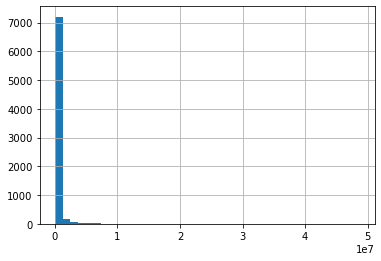

In [39]:
y_train_reg.hist(bins=40);

In [40]:
np.exp(np.log(y_train_reg+1))

3016    3.792141e+06
2569    5.656395e+05
2189    5.481558e+04
1166    7.762502e+05
959     1.000000e+00
            ...     
719     1.000000e+00
3975    2.223641e+06
9721    1.000000e+00
7684    8.350100e+04
1604    1.375100e+04
Name: sales_12M_2019, Length: 7503, dtype: float64

In [41]:
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

In [42]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb

In [43]:
def modified_log(x):
    x = np.where(x<0, 0, x)
    return np.log(x, where=x>0)

In [44]:
def modified_exp(x):
    x = np.where(x>15, 15, x)
    return np.expm1(x)

In [45]:
# ttr = TransformedTargetRegressor(
#         RidgeCV(), 
#         func=modified_log, 
#         inverse_func=modified_exp, 
#         check_inverse=False
# )

In [46]:
ttr = TransformedTargetRegressor(
        RidgeCV(), 
        func=np.log1p, 
        inverse_func=modified_exp, 
        check_inverse=False
)

In [47]:
ttr.fit(X_train_prepared, y_train_reg)

TransformedTargetRegressor(check_inverse=False, func=<ufunc 'log1p'>,
                           inverse_func=<function modified_exp at 0x129aa1160>,
                           regressor=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

[Back to Top](#Index)
# Make predictions

## Regression

In [48]:
test_preds = pd.Series(ttr.predict(X_test_prepared), index=y_test_reg.index)
test_preds

6307         3.064226
4521        97.427806
7859        12.029382
110          8.572280
4238        22.707121
            ...      
5710       292.812887
6026        79.301902
6246    782764.457229
8059     32928.482550
6438        31.448920
Length: 2502, dtype: float64

In [49]:
ttr.score(X_test_prepared, y_test_reg)

0.034779944502079885

[Back to Top](#Index)
### Make Function to output deciles

In [50]:
def output_deciles(model, X, y):
    results = pd.DataFrame(model.predict(X), index=y.index, columns=['prediction'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['prediction'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results

In [51]:
result_df = output_deciles(ttr, X_test_prepared, y_test_reg)
result_df

prediction     actual  deciles            contact_id
6307       3.064226       0.00        0               4495550
4521      97.427806       0.00        5  85102132724913032579
7859      12.029382       0.00        3               4380705
110        8.572280   25093.00        1  85102151525164324880
4238      22.707121     742.00        4  85101111303291084757
...             ...        ...      ...                   ...
5710     292.812887       0.00        6               0056157
6026      79.301902  750051.80        5  85202111474542078472
6246  782764.457229  264238.31        9  85201140523379459042
8059   32928.482550   37576.85        8  85202111325248394877
6438      31.448920       0.00        4               0315144

[2502 rows x 4 columns]

In [52]:
result_df[result_df['deciles'] == 9]

prediction        actual  deciles            contact_id
2990  5.409740e+05  7.189395e+04        9               4353864
6452  6.952845e+04  7.314998e+06        9  85202112173254510211
324   2.408189e+06  3.341190e+06        9  85101122913914154200
8940  1.683491e+06  1.319240e+06        9               4357613
4194  3.269016e+06  1.225482e+06        9               4434645
...            ...           ...      ...                   ...
4048  5.247587e+04  2.865495e+05        9               4331182
6461  1.150358e+05  7.594300e+04        9  85201131374086410352
8853  9.317475e+05  9.053720e+05        9               0347664
6265  7.345901e+04  9.170000e+02        9               4493012
6246  7.827645e+05  2.642383e+05        9  85201140523379459042

[251 rows x 4 columns]

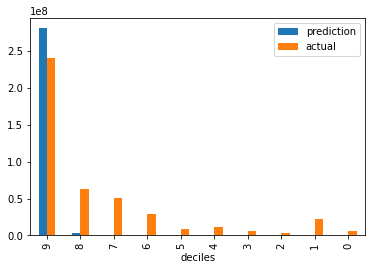

In [53]:
result_df.drop(columns='contact_id').groupby('deciles').sum().sort_index(ascending=False).plot(kind='bar');

[Back to Top](#Index)
## Classification

In [54]:
y_train_cl.value_counts()

0    5623
1    1880
Name: new_Fund_added_12M_2019, dtype: int64

In [55]:
y_test_cl.value_counts()

0    1861
1     641
Name: new_Fund_added_12M_2019, dtype: int64

In [56]:
from sklearn.ensemble import GradientBoostingClassifier

In [57]:
gbt_base = GradientBoostingClassifier()
gbt_base.fit(X_train_prepared, y_train_cl)
test_pred_class = gbt_base.predict(X_test_prepared)
print(classification_report(y_test_cl, test_pred_class))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1861
           1       0.52      0.10      0.17       641

    accuracy                           0.75      2502
   macro avg       0.64      0.54      0.51      2502
weighted avg       0.70      0.75      0.68      2502



In [58]:
def output_deciles_class(model, X, y):
    results = pd.DataFrame(model.predict_proba(X)[:,1], index=y.index, columns=['prediction'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['prediction'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results.sort_values(by='prediction', ascending=False)

In [59]:
output_deciles_class(gbt_base, X_train_prepared, y_train_cl)

prediction  actual  deciles            contact_id
1783    0.932667       1        9  85101103674323007541
7325    0.914916       1        9               4417770
7629    0.914758       1        9               0215284
6867    0.914558       1        9               0232384
5035    0.899724       1        9               4316840
...          ...     ...      ...                   ...
7905    0.071795       0        0               0035524
5275    0.071207       0        0               0298171
9418    0.069437       0        0               4484142
974     0.067010       0        0               0025009
4707    0.052451       0        0               0349532

[7503 rows x 4 columns]

### Balance the data with `imbalanced-learn`

In [60]:
from imblearn.over_sampling import SMOTE

In [61]:
X_train_prepared.head(2)

no_of_sales_12M_1  no_of_Redemption_12M_1  no_of_sales_12M_10K  \
3016          -0.196278               -0.101941            -0.213159   
2569          -0.083881               -0.092756            -0.213159   

      no_of_Redemption_12M_10K  no_of_funds_sold_12M_1  \
3016                 -0.202310               -0.568538   
2569                 -0.092965               -0.152531   

      no_of_funds_redeemed_12M_1  no_of_fund_sales_12M_10K  \
3016                   -0.626347                 -0.431731   
2569                    0.181888                 -0.431731   

      no_of_funds_Redemption_12M_10K  no_of_assetclass_sold_12M_1  \
3016                       -0.451524                    -0.784367   
2569                        0.284471                     0.213785   

      no_of_assetclass_redeemed_12M_1  no_of_assetclass_sales_12M_10K  \
3016                        -0.870084                       -0.539912   
2569                         0.088964                       -0.539912   

      no_of_assetclass_Redemption_12M_10K  No_of_fund_curr  No_of_asset_curr  \
3016                            -0.566298        -0.688081         -0.887018   
2569                             0.770265         1.221427          3.897522   

           AUM  sales_curr  sales_12M_2018  redemption_curr  redemption_12M  \
3016 -0.103503   -0.087693       -0.158849         0.090594        0.151819   
2569  0.005228   -0.087693       -0.143764         0.041500        0.123349   

      new_Fund_added_12M_2018  aum_AC_EQUITY  aum_AC_FIXED_INCOME_MUNI  \
3016                -0.412074      -0.020322                 -0.090999   
2569                 0.418829       0.151346                 -0.064646   

      aum_AC_FIXED_INCOME_TAXABLE  aum_AC_MONEY  aum_AC_MULTIPLE  \
3016                    -0.046796     -0.012455        -0.027474   
2569                    -0.018608     -0.012455         0.109718   

      aum_AC_PHYSICAL_COMMODITY  aum_AC_REAL_ESTATE  aum_AC_TARGET  aum_P_529  \
3016                  -0.044623           -0.029518      -0.039159  -0.082041   
2569                   0.455268           -0.029518      -0.039159  -0.082041   

      aum_P_ALT  aum_P_CEF  aum_P_ETF  aum_P_MF  aum_P_SMA  aum_P_UCITS  \
3016  -0.025459  -0.084761   -0.01501 -0.065685  -0.074575    -0.018967   
2569  -0.025459  -0.043016   -0.01501 -0.070373   0.157046    -0.018967   

      aum_P_UIT  
3016  -0.069496  
2569   0.002049

In [62]:
y_train_cl.value_counts()

0    5623
1    1880
Name: new_Fund_added_12M_2019, dtype: int64

In [63]:
# instantiate SMOTENC
smote = SMOTE(random_state=0)

# balance data
X_smote, y_smote = smote.fit_resample(X_train_prepared, y_train_cl)

In [64]:
y_smote.value_counts()

1    5623
0    5623
Name: new_Fund_added_12M_2019, dtype: int64

In [65]:
gbt_base2 = GradientBoostingClassifier()
gbt_base2.fit(X_smote, y_smote)
test_pred_class2 = gbt_base2.predict(X_test_prepared)
print(classification_report(y_test_cl, test_pred_class2))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1861
           1       0.46      0.54      0.50       641

    accuracy                           0.72      2502
   macro avg       0.65      0.66      0.65      2502
weighted avg       0.74      0.72      0.73      2502



[Back to Top](#Index)
# Model Interpretation

Using Shapley Values to Interpret Models: see [`shap`](https://github.com/slundberg/shap) package

In [66]:
# !pip install shap
# or
# !conda install -yc conda-forge shap

In [67]:
import shap

In [68]:
shap.initjs()

In [69]:
# initialize explainer
explainer = shap.LinearExplainer(ttr.regressor_, X_train_prepared)

# get shapley values using your data (like .fit method in sklearn)
shap_values = explainer.shap_values(X_test_prepared)

# visualize the first prediction's explaniation
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test_prepared.iloc[0, :])

In [70]:
# base value is mean of all training prediction
np.mean(ttr.regressor_.predict(X_train_prepared))

5.316026770041996

In [71]:
# the prediction for this advisor is the bold number
ttr.regressor_.predict(X_test_prepared.iloc[0, :].values.reshape(1,-1))

array([1.40222323])

In [72]:
# the numbers next to the features are the values for each feature
X_test_prepared.loc[6307, 'no_of_assetclass_sold_12M_1']

-0.7843666563004901

In [73]:
# The low value in 'no_of_assetclass_sold_12M_1' pushes the prediction down
X_test_prepared['no_of_assetclass_sold_12M_1'].describe()

count    2502.000000
mean        0.001548
std         1.011607
min        -0.784367
25%        -0.784367
50%        -0.784367
75%         0.213785
max         4.206392
Name: no_of_assetclass_sold_12M_1, dtype: float64

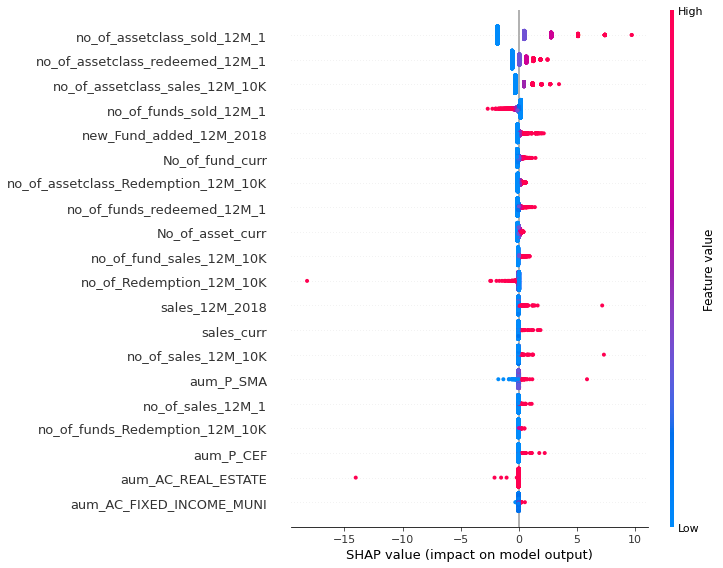

In [74]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test_prepared)

The above plot shows an overview of which features are most important for a model. The first features have the higest shapley value magnitudes over all samples. The colors represent the feature value. For example, a **high** number of `no_of_assetclass_sold_12M_1` **increases** the sales amount.

In [75]:
k = 1000
sample = X_test_prepared.sample(k, random_state=0)
shap_sample = pd.DataFrame(shap_values, index=X_test_prepared.index).loc[sample.index, :].values

In [76]:
# WARNING! This can be slow...
shap.force_plot(explainer.expected_value, shap_sample, sample)

In [77]:
# let's look at the top decile
reg_results_df = output_deciles(ttr, X_test_prepared, y_test_reg)
reg_results_df[reg_results_df['deciles'] == 9]

prediction        actual  deciles            contact_id
2990  5.409740e+05  7.189395e+04        9               4353864
6452  6.952845e+04  7.314998e+06        9  85202112173254510211
324   2.408189e+06  3.341190e+06        9  85101122913914154200
8940  1.683491e+06  1.319240e+06        9               4357613
4194  3.269016e+06  1.225482e+06        9               4434645
...            ...           ...      ...                   ...
4048  5.247587e+04  2.865495e+05        9               4331182
6461  1.150358e+05  7.594300e+04        9  85201131374086410352
8853  9.317475e+05  9.053720e+05        9               0347664
6265  7.345901e+04  9.170000e+02        9               4493012
6246  7.827645e+05  2.642383e+05        9  85201140523379459042

[251 rows x 4 columns]

Select only rows in testing from top decile

In [78]:
top_decile_test_idx = reg_results_df[reg_results_df['deciles'] == 9].index
top_decile_test = X_test_prepared.loc[top_decile_test_idx, :]
top_decile_shap = pd.DataFrame(shap_values, index=X_test_prepared.index).loc[top_decile_test_idx, :].values

In [79]:
shap.force_plot(explainer.expected_value, top_decile_shap, top_decile_test)

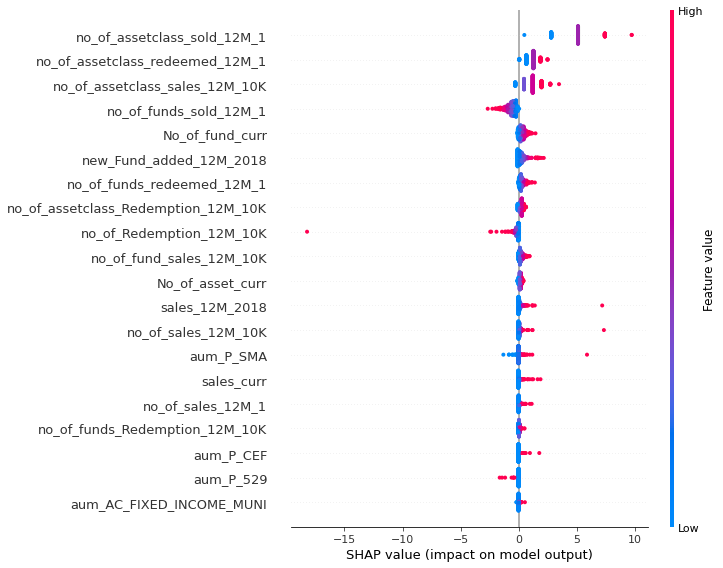

In [80]:
shap.summary_plot(top_decile_shap, top_decile_test)

[Back to Top](#Index)
# Fairness and Bias
1. [Visit the Aequitas project website](http://www.datasciencepublicpolicy.org/projects/aequitas/)
2. [Aequitas Fairness GitHub](https://github.com/dssg/aequitas)
3. [Aequitas API Docs](https://dssg.github.io/aequitas/api/aequitas.html)
4. [Aequitas Example](https://dssg.github.io/aequitas/examples/compas_demo.html)

In [82]:
# !pip install aequitas

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

import warnings; warnings.simplefilter('ignore')

In [84]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]

### Load sample data

In [85]:
RAW_DATA = 'https://raw.githubusercontent.com/dssg/aequitas/master/examples/data/compas_for_aequitas.csv'
df = pd.read_csv(RAW_DATA)

In [86]:
df.head()

entity_id  score  label_value              race   sex          age_cat
0          1    0.0            0             Other  Male  Greater than 45
1          3    0.0            1  African-American  Male          25 - 45
2          4    0.0            1  African-American  Male     Less than 25
3          5    1.0            0  African-American  Male     Less than 25
4          6    0.0            0             Other  Male          25 - 45

### About the data
Risk assessment by race

COMPAS produces a risk score that predicts a person’s likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of “low” risk according to COMPAS, while a 1 indicates “high” or “medium” risk.

In [87]:
aq_palette = sns.diverging_palette(225, 35, n=2)

Look at the prediction distributons along the race, sex, and age attributes.

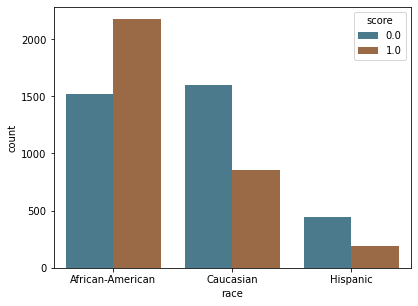

In [88]:
by_race = sns.countplot(
            x="race", hue="score", 
            data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])],
            palette=aq_palette
)

Race by label

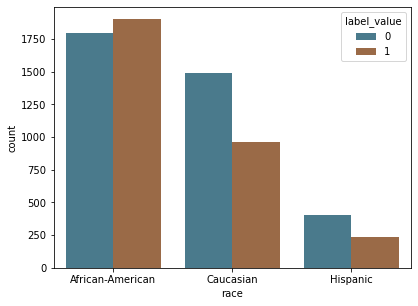

In [89]:
label_by_race = sns.countplot(
    x="race", hue="label_value", 
    data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], 
    palette=aq_palette
)

Predictions by Sex

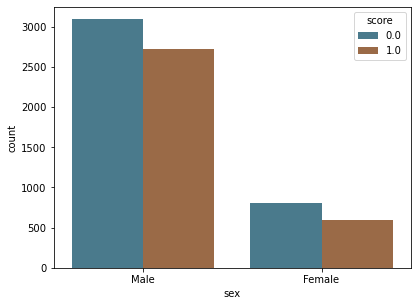

In [90]:
by_sex = sns.countplot(x="sex", hue="score", data=df, palette=aq_palette)

Labels by Sex

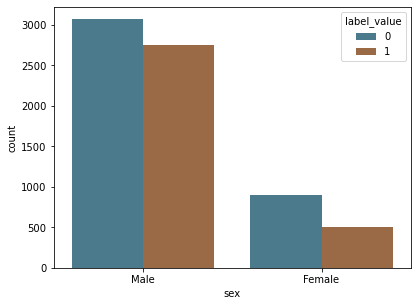

In [91]:
label_by_age = sns.countplot(
    x="sex", hue="label_value", 
    data=df, palette=aq_palette
)

Predictions by Age

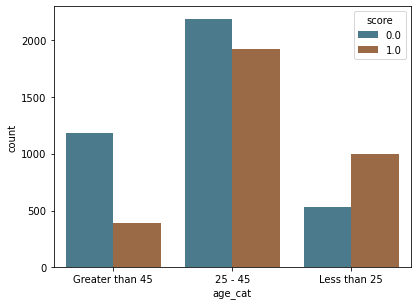

In [92]:
by_age = sns.countplot(x="age_cat", hue="score", data=df, palette=aq_palette)

Labels by Age

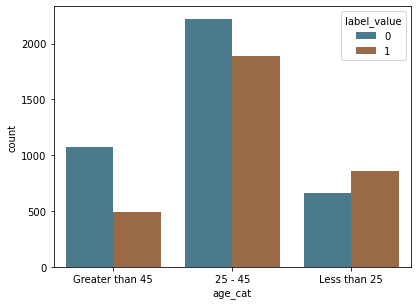

In [93]:
label_by_sex = sns.countplot(
    x="age_cat", hue="label_value", 
    data=df, palette=aq_palette
)

The graphs above show the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39), though the predictions do not match the base rates.

#### Initialize a `Group()` instance to see metrics in cross tabulations

In [94]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 0 {'rank_abs': [3317]}


In [95]:
xtab

model_id score_threshold     k attribute_name   attribute_value       tpr  \
0          0      binary 0/1  3317           race  African-American  0.720147   
1          0      binary 0/1  3317           race             Asian  0.666667   
2          0      binary 0/1  3317           race         Caucasian  0.522774   
3          0      binary 0/1  3317           race          Hispanic  0.443966   
4          0      binary 0/1  3317           race   Native American  0.900000   
5          0      binary 0/1  3317           race             Other  0.323308   
6          0      binary 0/1  3317            sex            Female  0.608434   
7          0      binary 0/1  3317            sex              Male  0.629132   
8          0      binary 0/1  3317        age_cat           25 - 45  0.626257   
9          0      binary 0/1  3317        age_cat   Greater than 45  0.427711   
10         0      binary 0/1  3317        age_cat      Less than 25  0.739583   

         tnr       for       fdr       fpr       fnr       npv  precision  \
0   0.551532  0.349540  0.370285  0.448468  0.279853  0.650460   0.629715   
1   0.913043  0.125000  0.250000  0.086957  0.333333  0.875000   0.750000   
2   0.765457  0.288125  0.408665  0.234543  0.477226  0.711875   0.591335   
3   0.785185  0.288591  0.457895  0.214815  0.556034  0.711409   0.542105   
4   0.625000  0.166667  0.250000  0.375000  0.100000  0.833333   0.750000   
5   0.852459  0.302013  0.455696  0.147541  0.676692  0.697987   0.544304   
6   0.678930  0.242537  0.487310  0.321070  0.391566  0.757463   0.512690   
7   0.675799  0.330100  0.364637  0.324201  0.370868  0.669900   0.635363   
8   0.666216  0.323112  0.385135  0.333784  0.373743  0.676888   0.614865   
9   0.832096  0.241117  0.459391  0.167904  0.572289  0.758883   0.540609   
10  0.458647  0.424528  0.360360  0.541353  0.260417  0.575472   0.639640   

      pp    pn       ppr     pprev   fp    fn    tn    tp  group_label_pos  \
0   2174  1522  0.655412  0.588203  805   532   990  1369             1901   
1      8    24  0.002412  0.250000    2     3    21     6                9   
2    854  1600  0.257462  0.348003  349   461  1139   505              966   
3    190   447  0.057281  0.298273   87   129   318   103              232   
4     12     6  0.003618  0.666667    3     1     5     9               10   
5     79   298  0.023817  0.209549   36    90   208    43              133   
6    591   804  0.178173  0.423656  288   195   609   303              498   
7   2726  3093  0.821827  0.468465  994  1021  2072  1732             2753   
8   1924  2185  0.580042  0.468240  741   706  1479  1183             1889   
9    394  1182  0.118782  0.250000  181   285   897   213              498   
10   999   530  0.301176  0.653368  360   225   305   639              864   

    group_label_neg  group_size  total_entities      prev  
0              1795        3696            7214  0.514340  
1                23          32            7214  0.281250  
2              1488        2454            7214  0.393643  
3               405         637            7214  0.364207  
4                 8          18            7214  0.555556  
5               244         377            7214  0.352785  
6               897        1395            7214  0.356989  
7              3066        5819            7214  0.473105  
8              2220        4109            7214  0.459723  
9              1078        1576            7214  0.315990  
10              665        1529            7214  0.565075

#### Plot the false negative rates

These show how often the model misses someone that does commit another crime within that group.

In [96]:
aqp = Plot()

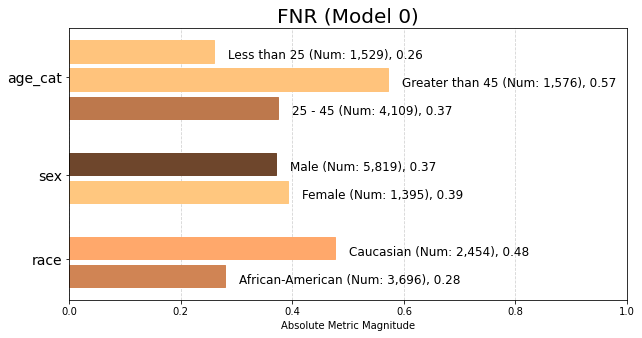

In [97]:
fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)

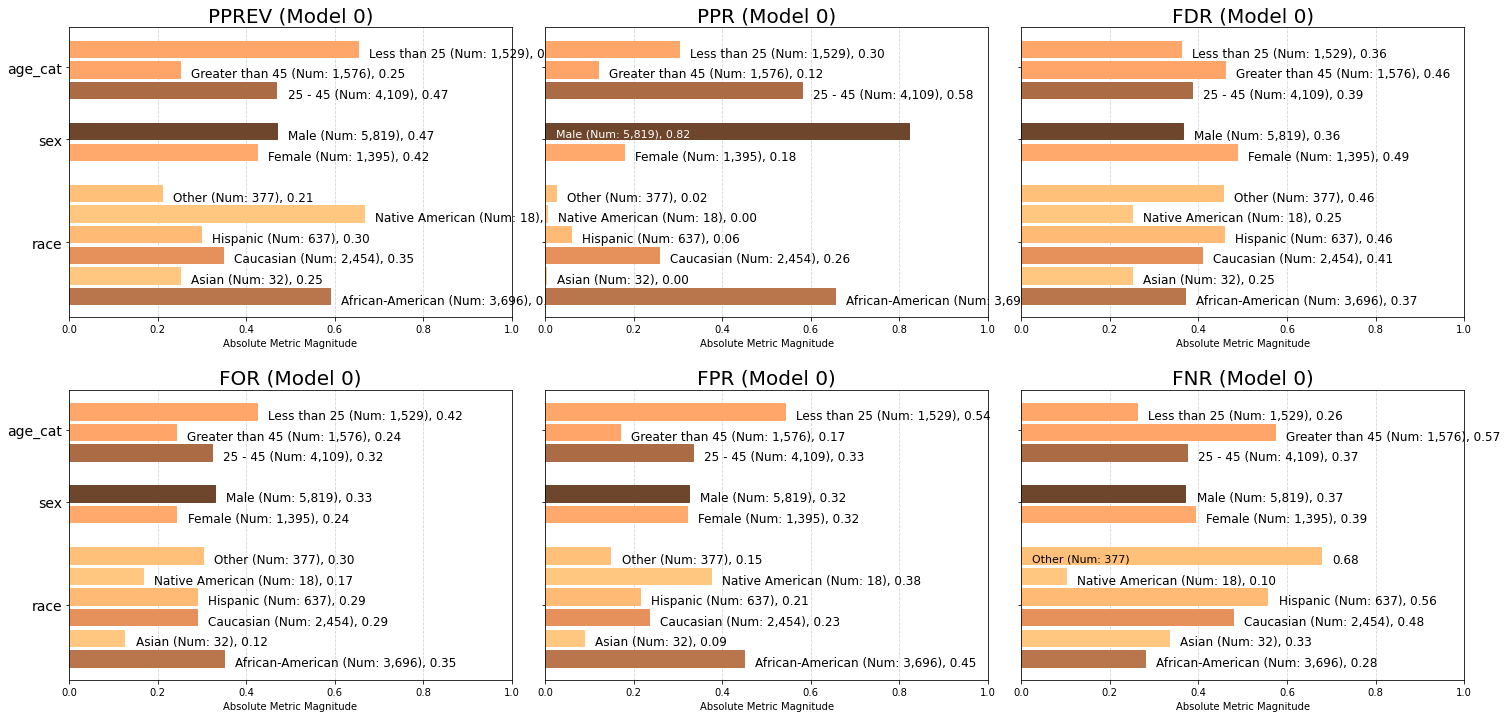

<Figure size 1080x720 with 0 Axes>

In [105]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

[Back to Top](#Index)
# Scratch Work

## Lift Chart Evaluation

In [ ]:
# conda install -yc conda-forge scikit-plot

In [ ]:
import scikitplot as skplt

In [ ]:
test_pred_proba = gbt_base2.predict_proba(X_test_prepared)

In [ ]:
skplt.metrics.plot_lift_curve(y_test_cl, test_pred_proba);

[Back to Top](#Index)
## Cross Validation

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
-cross_validate(feat_pipe, X_train_prepared, y_train_reg, scoring='neg_root_mean_squared_error')['test_score']

In [ ]:
def evaluate_model(model, X, y):
    print("Cross Validation Scores:")
    print(cross_validate(model, X, y, scoring='neg_root_mean_squared_error')['test_score'])
    print('-'*55)
    preds = np.exp(model.predict(X))
    lim = max(preds.max(), y.max())
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.scatter(x=y, y=preds, alpha=0.4)
    ax.plot([0, 10000], [0, 10000])
    ax.set_xlim([0, 10000])
    ax.set_ylim([0, 10000])
    ax.set_title("Actual vs Predicted - Regression")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted");

In [ ]:
evaluate_model(feat_pipe, X_train_prepared, y_train_reg)

In [ ]:
y_train_reg_log = np.log(y_train_reg+1)
y_test_reg_log = np.log(y_test_reg+1)

In [ ]:
feat_pipe.fit(X_train_prepared, y_train_reg_log)

In [ ]:
feat_pipe.predict(X_test_prepared)[0]

In [ ]:
np.exp(1.5966611)

In [ ]:
evaluate_model(feat_pipe, X_train, y_train_reg_log)

In [ ]:
evaluate_model(feat_pipe, X_test, y_test_reg_log)

[Back to Top](#Index)
## Feature Engineering

**What is feature engineering**?

"Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." - Andrew Ng

Feature engineering is the term broadly applied to the creation and manipulation of features (variables) used in machine learning algorithms. Unless we're working with the same data over and over again, this isn't something we can automate. It will require creativity and a good, thorough understanding of our data.

Regression results can change significantly depending on feature selection. Let's take a closer look at our features.

In [ ]:
X_train_prepared.corr().style.background_gradient().set_precision(2)

In [ ]:
X_train_prepared.hist(bins=40, figsize=(16,10));

[Back to Top](#Index)
### Variable Inflation Factor (VIF)

VIF measures the amount of multicollinearity in a set of multiple regressors, by evaluating how much the variance of the independent variable is inflated by it's interaction with other independent variables. VIF threshold of 5 to 10 are acceptable, but values above 10 are too high.  

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [ ]:
funds = pd.concat([X_train_prepared, y_train_reg.to_frame()], axis=1)
features = funds.columns.tolist()
target = 'sales_12M_2019'

In [ ]:
transformer = ReduceVIF()

X_tr_vif = transformer.fit_transform(X_train_prepared, y_train_reg)
X_tr_vif.head()

[Back to Top](#Index)
## Residuals

In [ ]:
y_test_preds = feat_pipe.predict(X_test_prepared)

In [ ]:
# get residuals
residuals = y_test_preds - y_test_reg

In [ ]:
# plot predictions vs residuals
fig, axes = plt.subplots(2,2,figsize=(14,10))

# plot scatter on upper right plot
axes[0,0].scatter(x=y_test_preds, y=residuals, alpha=0.5)
axes[0,0].set(xlabel="Residuals",ylabel="Predictions");

# plot hist on upper left plot
axes[0,1].hist(residuals, bins=50)
axes[0,1].set(xlabel='Residuals', ylabel='Frequency');

In [ ]:
from statsmodels.api import qqplot

In [ ]:
axes[1,0].set_ylim([-3.5, 3.5])
axes[1,0].set_xlim([-3.5, 3.5])

In [ ]:
qqplot(residuals, fit=True, line='r', ax=axes[1,0])

[Back to Top](#Index)
## Condition number

Numerical analysis has a notion of condition number, which measures how sensitive a function is to changes in the input, and how much error in the output results from an error in the input. In linear regression this number can be used to diagnose multicollinearity. 

In [ ]:
from numpy import linalg as LA
from itertools import chain, combinations

# Find all possible combinations of any length more than 2
def all_subsets(set_arg):
    return chain(*map(lambda x: combinations(set_arg, x), range(2, len(set_arg)+1)))

funds = pd.concat([X_train_prepared, y_train_reg.to_frame()], axis=1)
features = funds.columns.tolist() 
target = 'sales_12M_2019'

cond_nums = {}
for subset in all_subsets(features):
    # checking that target varaible is included in the matrix
    if target not in list(subset):
        continue
    cond_nums[', '.join(list(subset))] = LA.cond(funds[list(subset)])
    
sorted(cond_nums.items(), key=lambda x:x[1])